## 2. Train Object Classifier

**Model to identify causal relationships**: 
feature extraction network (ResNet18) trained on ImageNet and 
classifier network (two 512-unit hidden layers) trained on Pascal VOC 2012

### 2-1. Pascal VOC2012 Dataset

In [1]:
import os
import json
import tqdm
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import VOCDetection
from torchvision import transforms as T

In [2]:
# object categories in pascal voc
categories = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
    'dining table', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'television'
]
categories = {categories[i]: i for i in range(len(categories))}
categories['tvmonitor'] = categories['television']
categories['diningtable'] = categories['dining table']
categories['pottedplant'] = categories['potted plant']

In [3]:
transform = T.Compose([T.Resize((224,224)), T.ToTensor()])
dataset = VOCDetection('data/voc', image_set='train', download=True, transform=transform)

Using downloaded and verified file: data/voc\VOCtrainval_11-May-2012.tar
Extracting data/voc\VOCtrainval_11-May-2012.tar to data/voc


KeyboardInterrupt: 

In [ ]:
dataloader = DataLoader(dataset)

### 2-2. Feature (ResNet) Classifier Training

In [ ]:
def feature_extractor():
    model_ft = resnet18(pretrained=True)
    # finetune
    for param in model_ft.parameters():
        param.requires_grad = False
    # modify classifier
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Flatten()
    # features = model_ft._modules.get('avgpool')
    return model_ft

In [ ]:
class Classifier(nn.Module):
    #  train on Pascal VOC 2012 dataset!!
    def __init__(self, in_features=512, hidden_dim=512):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(in_features, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, 20)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.classifier(x)
        # softmax
        return x

In [ ]:
# train classifier (w/ feature extractor) on Pascal VOC2012
batch_size = 1
num_epoch = 1
device = 'cpu'

In [ ]:
resnet = feature_extractor().to(device)
classifier = Classifier().to(device)
# torch.save(classifier.state_dict(), 'results/object_classifier.pt')

resnet.eval()
classifier.train()

criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.RMSprop(classifier.parameters())

for image, anns in tqdm.tqdm(dataloader):
    target, target_names = [], []
    for obj in anns['annotation']['object']:
        if obj['name'][0] == 'tvmonitor':
            obj['name'][0] = 'television'
        target.append(categories[obj['name'][0]])
        target_names.append(obj['name'][0])
        # bboxs.append(obj['bndbox'])

    target = F.one_hot(torch.tensor(target), num_classes=20).sum(axis=0).reshape(1,-1)
        
    features = resnet(image)
    logodds = classifier(features)

    optimizer.zero_grad()
    loss = criterion(logodds, target)
    loss.backward()
    optimizer.step()

KeyboardInterrupt: 

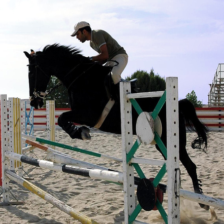

In [ ]:
# example
print(target_names)
image = T.ToPILImage()(image[0])
image